# CO Column Density Grid

November 22, 2023

Making a grid of CO 3-2/1-0 line ratios using Radex. Based on Lee's instruction from October.
Goal is to eventually use this grid to fit observed line ratios using Radex.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from spectralradex import radex

import itertools
import time
# from multiprocessing import Pool

Ok so we can't use the `radex.run_grid` function because, as demonstrated below, it uses the deprecated `pandas.DataFrame.append` method and I don't want to go in and fix that. I might as well write my own loop wrapper; I can even try using Pool eventually.

In [2]:
... # grid_df = radex.run_grid(radex.get_example_grid_parameters(), target_value="T_R (K)")

Ellipsis

In [3]:
params = radex.get_default_parameters()
tk = 30. # K
linewidth = 1. # km/s
# Setup fixed params
params = radex.get_default_parameters()
params['tkin'] = tk
params['fmin'] = 100.
params['fmax'] = 400.
params['linewidth'] = linewidth

# Define variable params
cdmol_arr = 10.**np.arange(11, 22, 0.5)
n_arr = 10.**np.arange(1, 10, 0.5)
# Result dict; figure out how to put it into arrays later (without rerunning radex a million times while debugging)
result_dict = {}

tic = time.perf_counter()
for coldens, dens in itertools.product(cdmol_arr, n_arr):
    params['cdmol'] = coldens
    params['h2'] = dens

    result_dict[(coldens, dens)] = radex.run(params)
# print(result_dict.keys())
toc = time.perf_counter()
print(f"manual grid took {toc-tic:0.4f} seconds without a pool")

 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines hav

 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines have very high optical depth
 *** Warning: Some lines hav

In [4]:
result_keys = list(result_dict.keys())
k1 = result_keys[0]
k1
result_dict[k1]

,E_UP (K),freq,WAVEL (um),T_ex,tau,T_R (K),POP UP,POP LOW,FLUX (K*km/s),FLUX (erg/cm2/s),Qup,Qlow
0,5.53,115.271202,2600.757633,2.803222,8.546001e-05,4.531020e-06,0.291230,0.698547,4.823270e-06,9.514053e-14,1,0
1,16.60,230.538000,1300.403656,2.853513,2.699797e-05,1.034135e-06,0.010050,0.291230,1.100837e-06,1.737026e-13,2,1
2,33.19,345.795990,866.963374,3.702044,8.460436e-07,1.282556e-07,0.000159,0.010050,1.365281e-07,7.270300e-14,3,2


In [22]:
# Functions operating on the full result DataFrame (3 lines: 1-0, 2-1, 3-2).
# Not using 2-1 line but expecting it to be there for indexing purposes.

def from_result_get_line_ratio(rdf):
    """
    3-2 / 1-0 line T_R ratio
    :param rdf: result DataFrame
    :returns: float line ratio
    """
    tr_col = rdf['T_R (K)']
    return tr_col.iloc[2] / tr_col.iloc[0]

def from_result_get_tr(rdf, line):
    """
    T_R (K) of either 1-0 or 3-2 line, specified by 'line' argument
    :param rdf: result DataFrame
    :param line: int 10 or 32
    :returns: float peak line brightness T_R (K) for that line
    """
    if line == 10:
        return rdf.iloc[0]['T_R (K)']
    elif line == 32:
        return rdf.iloc[2]['T_R (K)']
    else:
        raise RuntimeError(f"What line is <{line}>?")

def from_result_get_tex(rdf, line):
    """
    T_ex of either 1-0 or 3-2 line, specified by 'line' argument
    :param rdf: result DataFrame
    :param line: int 10 or 32
    :returns: float excitation temperature T_ex for that line
    """
    if line == 10:
        return rdf.iloc[0]['T_ex']
    elif line == 32:
        return rdf.iloc[2]['T_ex']
    else:
        raise RuntimeError(f"What line is <{line}>?")

def from_result_get_tau(rdf, line):
    """
    Optical depth of either 1-0 or 3-2 line, specified by 'line' argument
    :param rdf: result DataFrame
    :param line: int 10 or 32
    :returns: float optical depth for that line
    """
    # Get iloc index, we know in advance where these are in the DataFrame
    if line == 10:
        return rdf.iloc[0]['tau']
    elif line == 32:
        return rdf.iloc[2]['tau']
    else:
        raise RuntimeError(f"What line is <{line}>?")
        
# Function to get grid index from cdmol and n
def find_grid_index(cdmol, n):
    """
    Return grid index (i, j) for this cdmol and n value
    The cdmol_arr and n_arr must be defined and unchanged
    Will return the FIRST instance of each. However, the arrays should only have one instance of each.
    :param cdmol: float column density
    :param n: float density
    :returns: tuple(i, j) where i, j are indices. This tuple can directly index a 2d array
    """
    return (np.where(cdmol_arr == cdmol)[0][0], np.where(n_arr == n)[0][0])

In [33]:
line_ratio_grid = np.zeros((cdmol_arr.size, n_arr.size))
tau10_grid, tau32_grid = [line_ratio_grid.copy() for x in range(2)]
tr10_grid, tex10_grid, tex32_grid = [line_ratio_grid.copy() for x in range(3)]

for k in result_keys:
    idx = find_grid_index(*k)
    rdf = result_dict[k]
    line_ratio_grid[idx] = from_result_get_line_ratio(rdf)
    tau10_grid[idx] = from_result_get_tau(rdf, 10)
    tau32_grid[idx] = from_result_get_tau(rdf, 32)
    tr10_grid[idx] = from_result_get_tr(rdf, 10)
    tex10_grid[idx] = from_result_get_tex(rdf, 10)
    tex32_grid[idx] = from_result_get_tex(rdf, 32)

<IPython.core.display.Javascript object>


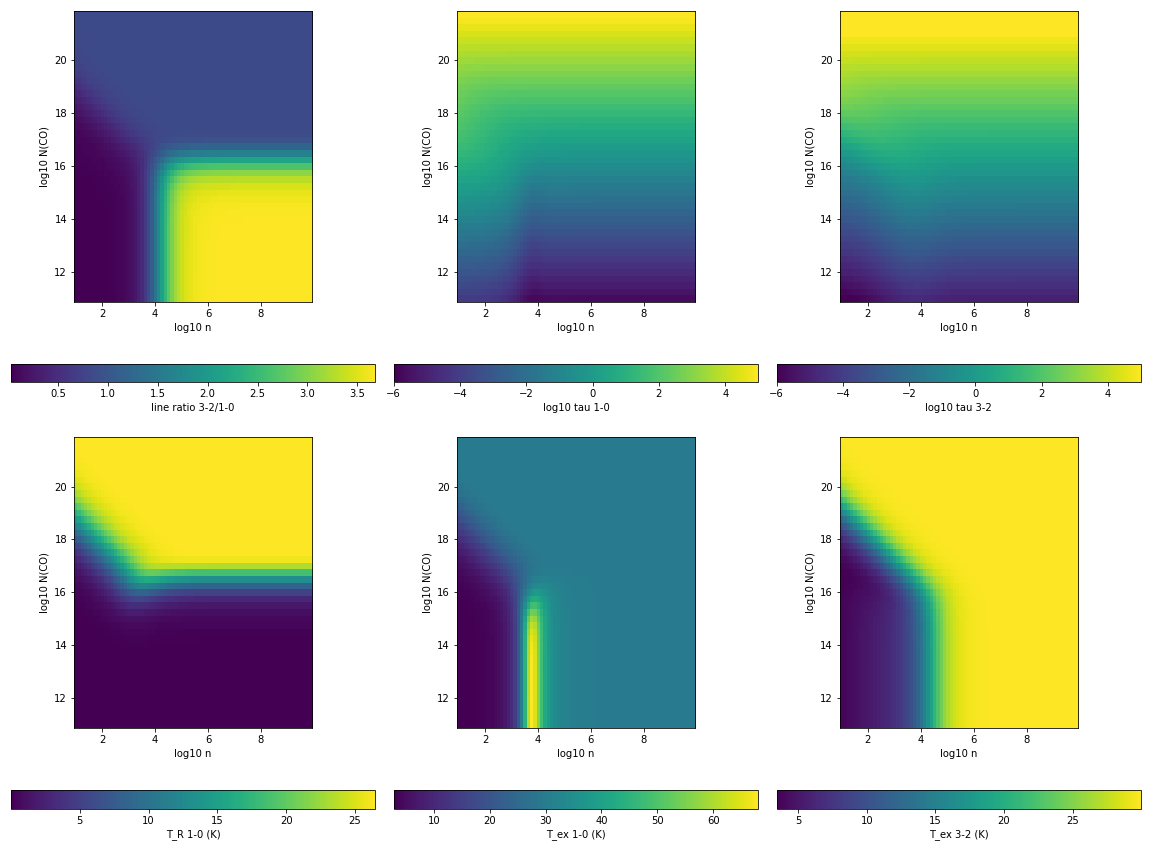

In [34]:
%matplotlib nbagg
def calculate_extent(arr):
    """
    Calculate the image "extent" needed to let the "0" pixel in the image be defined as the beginning of the array
    (Deal with the 0.5s and all that)
    :param arr: array whose first element should lie at the "0" point on the image axis
    """
    diff = np.diff(arr)[0]
    tmp_arr = arr - diff/2
    return [tmp_arr[0], tmp_arr[-1]+diff]

grid_names = ['line ratio 3-2/1-0', 'log10 tau 1-0', 'log10 tau 3-2', "T_R 1-0 (K)", "T_ex 1-0 (K)", "T_ex 3-2 (K)"]
fig = plt.figure(figsize=(16, 12))
for i, grid in enumerate((line_ratio_grid, np.log10(tau10_grid), np.log10(tau32_grid), tr10_grid, tex10_grid, tex32_grid)):
    plt.subplot(2, 3, 1+i)
    vlims = {}
    if i in [1, 2]:
        vlims['vmin'] = -6
        vlims['vmax'] = 5
    plt.imshow(grid,
               extent=calculate_extent(np.log10(n_arr)) + calculate_extent(np.log10(cdmol_arr)),
    #            interpolation='nearest',
              origin='lower', **vlims)
    plt.colorbar(label=grid_names[i], orientation='horizontal')
    plt.xlabel("log10 n")
    plt.ylabel("log10 N(CO)")
plt.tight_layout()
plt.savefig("/home/ramsey/Pictures/2023-11-22/radex_co_32_10_more.png", facecolor='w')

In [14]:
print(line_ratio_grid.shape)
print(cdmol_arr.shape)

(44, 72)
(44,)
